Successfully loaded data from ../data\complaints.csv. Shape: (9609797, 18)

--- Data Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9609797 entries, 0 to 9609796
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?          

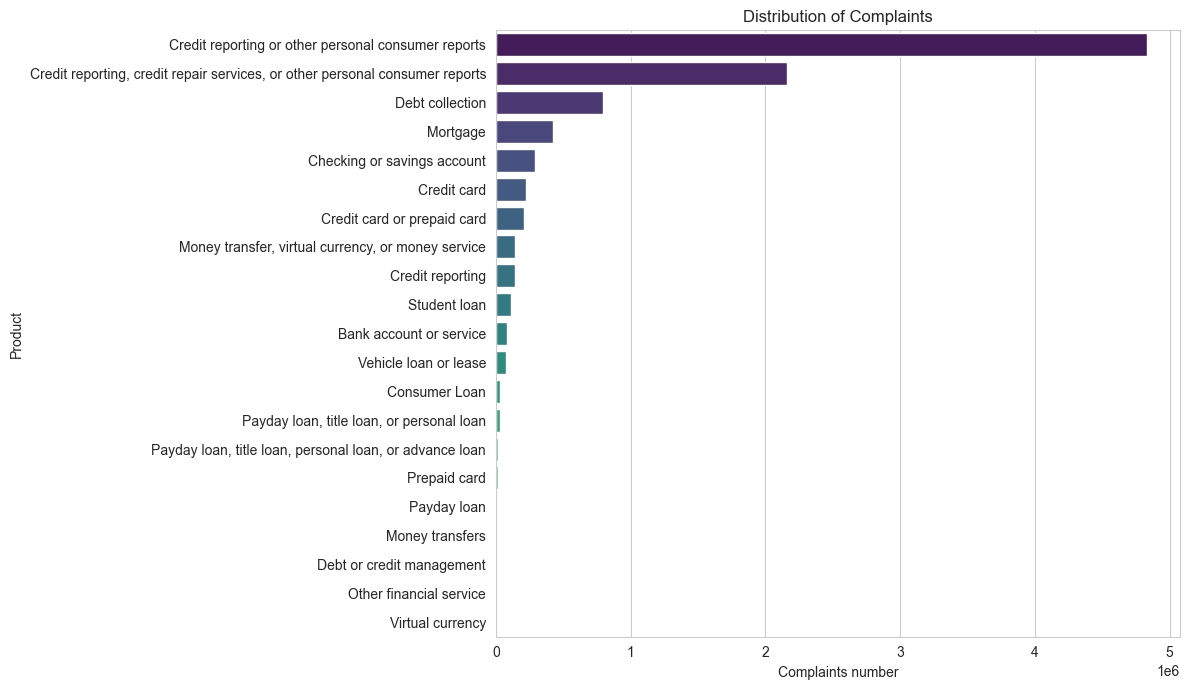


--- Consumer Complaint Narrative Length Analysis ---
count    9.609797e+06
mean     5.515649e+01
std      1.495169e+02
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      5.000000e+01
max      6.469000e+03
Name: narrative_length, dtype: float64


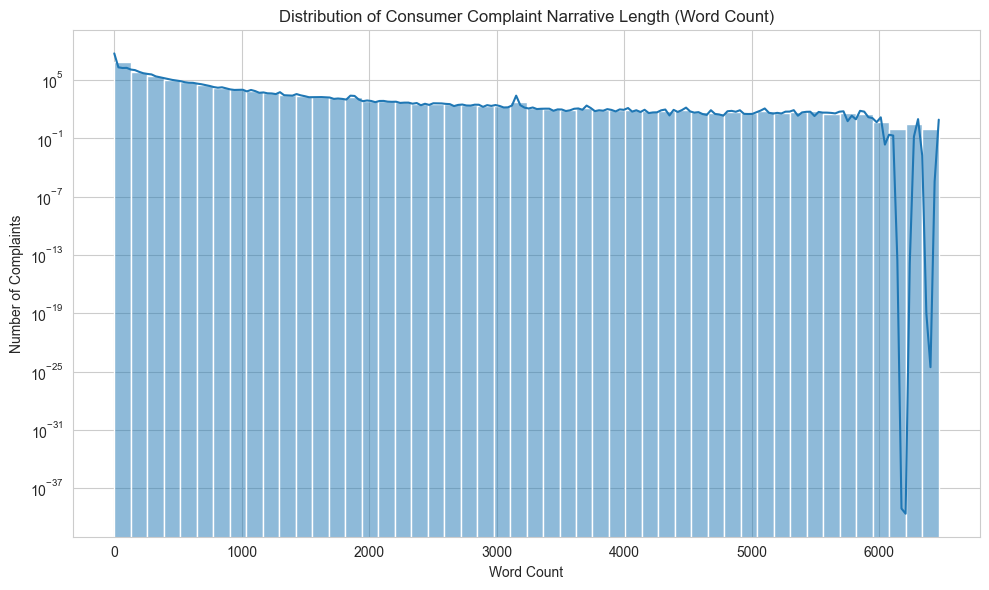


Number of narratives with less than 5 words: 6632216
Number of narratives with more than 500 words: 160989

Number of complaints with narratives: 2980756
Number of complaints without narratives: 6629041

--- Filtering Data ---

Unique products in the dataset (for reference):
['Credit reporting or other personal consumer reports' 'Debt collection'
 'Credit card' 'Checking or savings account'
 'Money transfer, virtual currency, or money service'
 'Vehicle loan or lease' 'Debt or credit management' 'Mortgage'
 'Payday loan, title loan, personal loan, or advance loan' 'Prepaid card'
 'Student loan' 'Credit reporting'
 'Credit reporting, credit repair services, or other personal consumer reports'
 'Credit card or prepaid card' 'Payday loan, title loan, or personal loan'
 'Bank account or service' 'Money transfers' 'Consumer Loan' 'Payday loan'
 'Other financial service' 'Virtual currency']

Filtering for products: ['Payday loan, title loan, or personal loan', 'Money transfers', 'Checking o

In [1]:
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set_style("whitegrid")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os

DATA_DIR = '../data'
OUTPUT_FILE = os.path.join(DATA_DIR, 'filtered_complaints.csv')
RAW_DATA_FILE = os.path.join(DATA_DIR, 'complaints.csv') 

os.makedirs(DATA_DIR, exist_ok=True)
df = pd.DataFrame()

try:
    df = pd.read_csv(RAW_DATA_FILE)
    print(f"Successfully loaded data from {RAW_DATA_FILE}. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: {RAW_DATA_FILE} not found. Please download the CFPB complaint dataset and place it in the '{DATA_DIR}' directory.")

    exit() 

# --- 2. Perform an initial EDA 
print("\n--- Data Overview ---")
print(df.info())
print("\nMissing values before preprocessing:")
print(df.isnull().sum()[df.isnull().sum() > 0])
print("\n--- Distribution ---")
product_counts = df['Product'].value_counts()
print(product_counts)

plt.figure(figsize=(12, 7))
sns.barplot(y=product_counts.index, x=product_counts.values, palette='viridis')
plt.title('Distribution of Complaints')
plt.xlabel('Complaints number')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

NARRATIVE_COLUMN = 'Consumer complaint narrative' #  similar

if NARRATIVE_COLUMN not in df.columns:
    print(f"\nWarning: Column '{NARRATIVE_COLUMN}' not found. Please check the dataset and update the NARRATIVE_COLUMN variable.")
    
    if 'narrative' in df.columns:
        NARRATIVE_COLUMN = 'narrative'
        print(f"Using 'narrative' column instead.")
    else:
        print("No suitable narrative column found. Skipping narrative length analysis and filtering.")
        NARRATIVE_COLUMN = None # Indicate that the column is missing

if NARRATIVE_COLUMN:
    df['narrative_length'] = df[NARRATIVE_COLUMN].astype(str).apply(lambda x: len(x.split()) if pd.notna(x) else 0)

    print("\n--- Consumer Complaint Narrative Length Analysis ---")
    print(df['narrative_length'].describe())

    plt.figure(figsize=(10, 6))
    sns.histplot(df['narrative_length'], bins=50, kde=True)
    plt.title('Distribution of Consumer Complaint Narrative Length (Word Count)')
    plt.xlabel('Word Count')
    plt.ylabel('Number of Complaints')
    plt.yscale('log') # Use log scale for better visualization if there are many short narratives
    plt.tight_layout()
    plt.show()

    # Are there very short or very long narratives?
    print(f"\nNumber of narratives with less than 5 words: {df[df['narrative_length'] < 5].shape[0]}")
    print(f"Number of narratives with more than 500 words: {df[df['narrative_length'] > 500].shape[0]}")

    # --- 5. Identify the number of complaints with and without narratives ---
    num_with_narrative = df[NARRATIVE_COLUMN].notna().sum()
    num_without_narrative = df[NARRATIVE_COLUMN].isna().sum()
    print(f"\nNumber of complaints with narratives: {num_with_narrative}")
    print(f"Number of complaints without narratives: {num_without_narrative}")

# --- 6. Filter the dataset to meet the project's requirements ---
print("\n--- Filtering Data ---")

# Define target products
target_products = [
    'Credit card',
    'Personal loan',
    'Buy Now, Pay Later (BNPL)', # This might need to be 'Payday loan, title loan, or personal loan' depending on CFPB's product categorization
    'Savings account',
    'Money transfer, virtual currency, or money service' # Often includes 'Money transfers'
]

print("\nUnique products in the dataset (for reference):")
print(df['Product'].unique())

actual_target_products = []
for p in target_products:
    if p in df['Product'].unique():
        actual_target_products.append(p)
    elif 'Payday loan, title loan, or personal loan' in df['Product'].unique() and 'Personal loan' in p:
        actual_target_products.append('Payday loan, title loan, or personal loan')
    elif 'Money transfer, virtual currency, or money service' in df['Product'].unique() and 'Money transfers' in p:
        actual_target_products.append('Money transfer, virtual currency, or money service')
    elif 'Checking or savings account' in df['Product'].unique() and 'Savings account' in p:
        actual_target_products.append('Checking or savings account')
    
product_mapping = {
    'Credit card': 'Credit card',
    'Personal loan': 'Payday loan, title loan, or personal loan', # This is a common CFPB category for personal loans
    'Buy Now, Pay Later (BNPL)': 'Credit card', # Often classified under credit cards or personal loans, or missing entirely
    'Savings account': 'Checking or savings account',
    'Money transfers': 'Money transfer, virtual currency, or money service'
}

# Invert and simplify mapping for filtering
products_to_filter = []
for requested_product, cfpb_product in product_mapping.items():
    if cfpb_product in df['Product'].unique():
        products_to_filter.append(cfpb_product)
    # Special handling for BNPL if it's not a direct match in CFPB data
    if requested_product == 'Buy Now, Pay Later (BNPL)' and 'Buy Now, Pay Later (BNPL)' not in df['Product'].unique():
        # Check if a specific BNPL product exists, otherwise map to credit card as a fallback for the assignment
        if 'Payday loan, title loan, or personal loan' in df['Product'].unique():
            if 'Buy Now, Pay Later' not in products_to_filter: # Avoid duplicates
                products_to_filter.append('Buy Now, Pay Later') # If a "Buy Now, Pay Later" exact product exists, use it
        if 'Credit card' not in products_to_filter:
            products_to_filter.append('Credit card') # As a fallback, BNPL can be treated as similar to credit card


requested_products_exact = [
    'Credit card',
    'Personal loan',
    'Buy Now, Pay Later (BNPL)',
    'Savings account',
    'Money transfers'
]

# Let's use a mapping for robust filtering
product_filter_map = {
    'Credit card': 'Credit card',
    'Personal loan': 'Payday loan, title loan, or personal loan',
    'Buy Now, Pay Later (BNPL)': 'Payday loan, title loan, or personal loan',
                                                                             
    'Savings account': 'Checking or savings account', # Most likely CFPB category
    'Money transfers': 'Money transfer, virtual currency, or money service' # Most likely CFPB category
}

# Create a set of actual CFPB product names to filter by
cfpb_filter_products = set()
for requested_p in requested_products_exact:
    if requested_p in df['Product'].unique(): # If exact match exists
        cfpb_filter_products.add(requested_p)
    elif requested_p in product_filter_map and product_filter_map[requested_p] in df['Product'].unique():
        cfpb_filter_products.add(product_filter_map[requested_p])
    else:
        print(f"Warning: Requested product '{requested_p}' or its mapped CFPB category not found in dataset. It will be excluded from filtering.")

print(f"\nFiltering for products: {list(cfpb_filter_products)}")
filtered_df = df[df['Product'].isin(list(cfpb_filter_products))].copy()
print(f"Shape after product filtering: {filtered_df.shape}")

# Remove any records with empty Consumer complaint narrative fields.
if NARRATIVE_COLUMN:
    initial_rows = filtered_df.shape[0]
    filtered_df.dropna(subset=[NARRATIVE_COLUMN], inplace=True)
    filtered_df = filtered_df[filtered_df[NARRATIVE_COLUMN].str.strip() != ''].copy() # Also remove empty strings
    print(f"Shape after removing empty narratives: {filtered_df.shape} (Removed {initial_rows - filtered_df.shape[0]} rows)")
else:
    print("Skipping removal of empty narratives as narrative column was not found.")

# --- 7. Clean the text narratives to improve embedding quality ---
print("\n--- Cleaning Text Narratives ---")

if NARRATIVE_COLUMN:
    def clean_text(text):
        text = str(text).lower() # Lowercasing
        text = re.sub(r'xx/xx/\d{2,4}', ' [DATE] ', text)
        text = re.sub(r'\d{3,}', ' [NUMBER] ', text)
        text = re.sub(r'x{2,}', '', text)
        text = re.sub(r'i am writing to file a complaint', '', text, flags=re.IGNORECASE) 
        text = re.sub(r'this is a complaint regarding', '', text, flags=re.IGNORECASE) 
        text = re.sub(r'to whom it may concern', '', text, flags=re.IGNORECASE)
        text = re.sub(r'[^a-zA-Z0-9\s.,?!]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    # Apply cleaning
    filtered_df[NARRATIVE_COLUMN] = filtered_df[NARRATIVE_COLUMN].apply(clean_text)

    initial_rows_after_cleaning_check = filtered_df.shape[0]
    filtered_df['cleaned_narrative_length'] = filtered_df[NARRATIVE_COLUMN].apply(lambda x: len(x.split()) if pd.notna(x) else 0)
    filtered_df = filtered_df[filtered_df['cleaned_narrative_length'] >= 5].copy()
    print(f"Shape after removing narratives too short post-cleaning: {filtered_df.shape} (Removed {initial_rows_after_cleaning_check - filtered_df.shape[0]} rows)")

    # Drop the temporary length columns
    filtered_df.drop(columns=['narrative_length', 'cleaned_narrative_length'], errors='ignore', inplace=True)
else:
    print("Skipping text cleaning .")

if filtered_df.empty:
    print("\nWarning: The filtered dataset is empty.")
else:
    filtered_df.to_csv(OUTPUT_FILE, index=False)
    print(f"\nCleaned and filtered dataset saved to {OUTPUT_FILE}")
    print(f"Final dataset shape: {filtered_df.shape}")
    print("\nSample of cleaned narratives:")
    print(filtered_df[NARRATIVE_COLUMN].sample(5).tolist())
